In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
# parameters
release_zone = "test_1500"
number_particles = 100000
start_year = 2009
start_month = 1
start_day = 1
runtime_in_days = 42

In [6]:
#SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_mfdataset('/gxfs_work1/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS119/Track-Column_test_1500_2009*_RT-42_N-100000_seed-12345.nc',concat_dim="traj",
    combine="nested",)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 7300000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(100000, 44), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    topography  (traj, obs) float32 dask.array<chunksize=(100000, 44), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [7]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT.rename({'lat','lon'})
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

In [8]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [9]:
release_locations = load_release_locations(release_locations_file = "../../data/config/test_stations.csv")
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 1500.0)

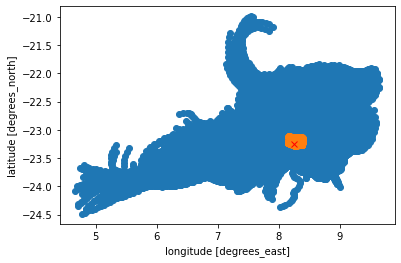

In [10]:
particle_ds.isel(traj=slice(None,None,2000)).plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0,traj=slice(None,None,2000)).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

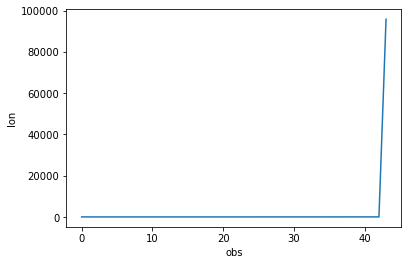

In [61]:
particle_ds.lon.isnull().sum("traj").plot()

In [11]:
MLD = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80-full.csv',index_col=0)

In [13]:
#Mixed layer depth first 5 days
MLD_INALT_5d = np.mean(MLD.INALT[MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
MLD_ROMS_5d = np.mean(MLD.ROMS[MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
MLD_ROMSchild_5d = np.mean(MLD.ROMSchild[MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])

In [15]:
depthML = particle_ds.where(particle_ds.z < MLD_INALT_5d,drop=True)
depthML

<xarray.Dataset>
Dimensions:     (traj: 120745, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(1756, 44), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(1756, 44), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(1756, 44), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(1756, 44), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(1756, 44), meta=np.ndarray>
    topography  (traj, obs) float32 dask.array<chunksize=(1756, 44), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [19]:
traj_plot = depthML.isel(traj=slice(None,None,1200),obs=slice(0,42,2))
start = traj_plot.isel(obs=0)
traj_plot

<xarray.Dataset>
Dimensions:     (traj: 101, obs: 21)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(2, 21), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(2, 21), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(2, 21), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(2, 21), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(2, 21), meta=np.ndarray>
    topography  (traj, obs) float32 dask.array<chunksize=(2, 21), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [17]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

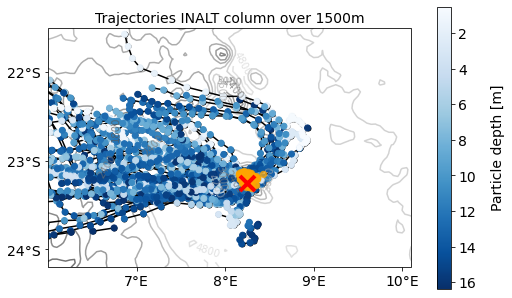

In [25]:
fig, ax = plt.subplots(1,1,figsize=(7,6),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([6,10.1,
               -24.2,-21.5], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)
ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',
              #vmin=0,vmax=1500,
             )
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
#cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
#c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,levels=10,
             alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_yticks([-22,-23.,-24])
ax.set_yticklabels(['22°S','23°S','24°S'],fontsize=14, family='Arial')

ax.set_title('Trajectories INALT column over 1500m', fontsize = 14)

plt.show()

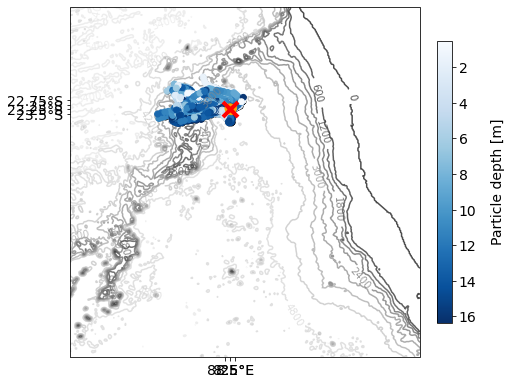

In [24]:
fig, ax = plt.subplots(1,1,figsize=(7,6),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([8,8.5,
               -23.5,-22.7], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)
ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',
              #vmin=0,vmax=1500,
             )
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
#topography lines
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,levels=10,
             alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([8,8.25,8.5])
ax.set_xticklabels(['8°E','8.25°E','8.5°E'],fontsize=14, family='Arial')
ax.set_yticks([-22.75,-23.,-23.25,-23.5])
ax.set_yticklabels(['22.75°S','23°S','23.25°S','23.5°S'],fontsize=14, family='Arial')

plt.show()

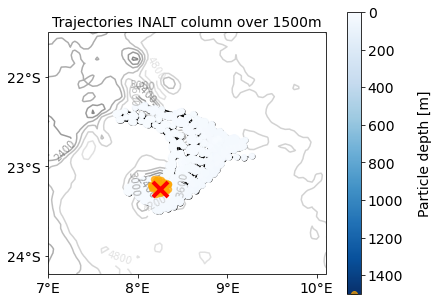

In [74]:
fig, ax = plt.subplots(1,1,figsize=(6,6),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7,10.1,
               -24.2,-21.5], crs=ccrs.PlateCarree())

#start points
ax.scatter(start['lon'].T,start['lat'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)
ax.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx',markersize=15,markeredgewidth=4,zorder=3)

#trajectories
sc=ax.scatter(traj_plot['lon'].T, traj_plot['lat'].T,c=traj_plot['z'].T, zorder=2,cmap='Blues',vmin=0,vmax=1500)
ax.plot(traj_plot['lon'].T, traj_plot['lat'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#colorbar
cb = fig.colorbar(sc,shrink=0.662)
cb.ax.invert_yaxis()
sc.figure.axes[1].tick_params(axis="y", labelsize=14)
cb.ax.set_ylabel('Particle depth [m]',fontsize=14)
cb.ax.get_yaxis().labelpad = 15
cb.ax.plot(0.5, release_depth, 'orange',marker='o',alpha=0.7)

#topography lines
#c=ax.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #ROMS
c=ax.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],topo_INALT,levels=10,alpha=0.7,zorder=0,cmap='Greys_r') #INALT
ax.clabel(c, c.levels, inline=True, fontsize=10,fmt=fmt)

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_yticks([-22,-23.,-24])
ax.set_yticklabels(['22°S','23°S','24°S'],fontsize=14, family='Arial')
ax.set_title('Trajectories INALT column over 1500m', fontsize = 14)

plt.show()

In [36]:
topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(bathymodiolus_lon-3,
                         bathymodiolus_lon+2,None))

<xarray.DataArray (lon: 101)>
array([2596.87388572, 2542.78190464, 2500.77414814, 2460.766761  ,
       2455.76583761, 2435.76214404, 2364.74878948, 2322.740027  ,
       2317.73898385, 2283.73189042, 2259.72688329, 2281.73147316,
       2305.73648029, 2316.73877522, 2325.7406529 , 2334.74253057,
       2339.74357372, 2351.74607729, 2344.74461687, 2328.74127879,
       2350.74586866, 2374.87020686, 2445.76399082, 2458.76639164,
       2447.76436018, 2460.766761  , 2507.77544089, 2512.77636428,
       2535.78061189, 2437.76251339, 2360.74795496, 2277.73063863,
       2798.8242537 , 3245.88197414, 3363.89422171, 3508.9081987 ,
       3628.91813151, 3736.92675144, 3815.93242758, 4010.94522967,
       4186.95472896, 4319.96127288, 4447.96687461, 4641.9742448 ,
       4695.97616358, 4686.97584378, 4644.9743514 , 4602.97285902,
       4643.97431587, 4674.97541739, 4624.97364074, 4438.96648074,
       4102.95021679, 3743.92731014, 3429.90058365, 3163.87250615,
       2900.83881144, 2485.77137796, 1992.66764119, 1377.51687301,
       1037.45389569,  953.4461184 , 1461.53714804, 2737.81447727,
       3505.90790952, 4086.94935733, 4502.9692816 , 4620.97349861,
       4546.97086918, 4462.96753106, 4461.9674873 , 4501.96923784,
       4481.96836257, 4399.96477396, 4388.96429256, 4457.96731225,
       4555.97118898, 4564.97150877, 4504.96936913, 4501.96923784,
       4505.90184838, 4505.90184838, 4469.96783741, 4404.96499278,
       4336.96201686, 4303.96057267, 4318.96122912, 4321.96136041,
       4311.96092277, 4305.96066019, 4290.96000374, 4259.63978546,
       4254.95838166, 4227.95693132, 4218.95644788, 4176.9541918 ,
       4145.95252659, 4124.95139855, 4100.95010936, 4074.94871274,
       4049.94736983])
Coordinates:
  * lon      (lon) float32 5.25 5.3 5.35 5.4 5.45 ... 10.1 10.15 10.2 10.25
    lat      float32 -23.24

In [45]:
traj_plot

<xarray.Dataset>
Dimensions:      (traj: 101)
Dimensions without coordinates: traj
Data variables:
    lon          (traj) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    lat          (traj) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    z            (traj) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    time         (traj) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    trajectory   (traj) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    topography   (traj) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    depth_layer  (traj) int64 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [56]:
particle_ds['depth_layer'] = (particle_ds['z'] / 5).astype(int) * 5

In [57]:
mean_position = particle_ds.isel(obs=5).groupby('depth_layer').mean()['lon']

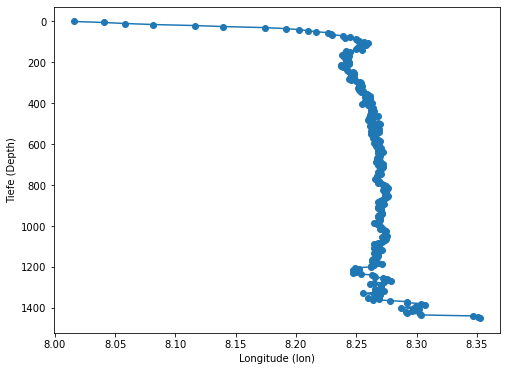

In [58]:
lon_values = mean_position.values
depth_values = mean_position.depth_layer.values  # Beachten Sie, dass dies von Ihrer xarray-Dimension abhängt

# Plotten Sie den Tiefenschnitt
plt.figure(figsize=(8, 6))
plt.plot(lon_values, depth_values, marker='o', linestyle='-')
plt.xlabel('Longitude (lon)')
plt.ylabel('Tiefe (Depth)')
plt.gca().invert_yaxis()  # Umkehren der y-Achse, damit die Tiefe nach unten zunimmt
plt.show()


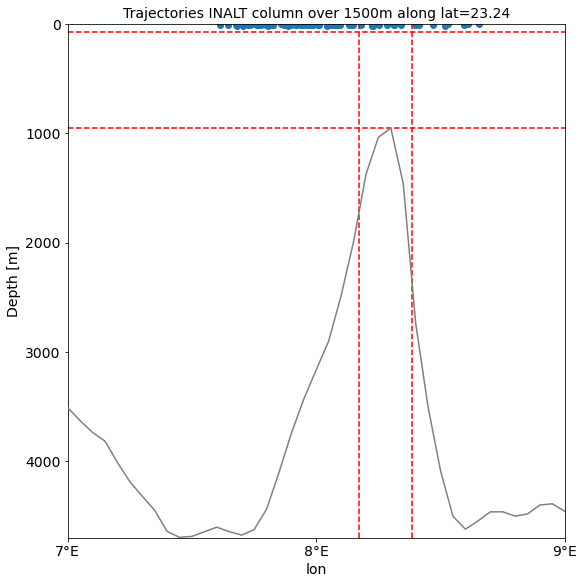

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True,
                      )


#start points
#ax.scatter(start['lon'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot.isel(obs=3)['lon'].T, traj_plot.isel(obs=3)['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
#ax.plot(traj_plot.isel(obs=1)['lon'].T, traj_plot.isel(obs=1)['z'].T, zorder=1, marker='o',markersize=1,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#topography lines
topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(bathymodiolus_lon-3,
                         bathymodiolus_lon+2,None)).plot(zorder=3, color='gray')

plt.axhline(953,color='red',linestyle='--')
plt.axhline(76.8,color='red',linestyle='--')
plt.axvline(8.17,color='red',linestyle='--')
plt.axvline(8.385,color='red',linestyle='--')

#labels
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'],fontsize=14, family='Arial')
ax.set_xlabel('lon',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks([0,1000,2000,3000,4000])
ax.set_yticklabels(['0','1000','2000','3000','4000'],fontsize=14, family='Arial')

ax.set_title('Trajectories INALT column over 1500m along lat=23.24', fontsize = 14)
ax.invert_yaxis()
ax.set_xlim([7,9])
ax.set_ylim([4700,0])
plt.show()

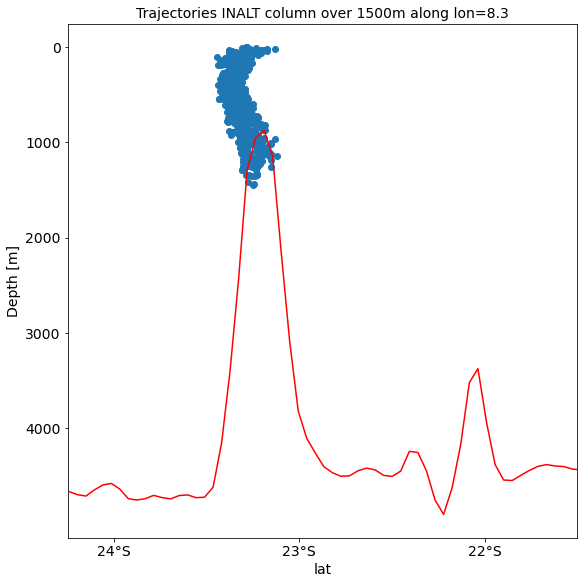

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True,
                      )


#start points
#ax.scatter(start['lat'].T,start['z'].T,zorder=3,linewidth=1.5,color='orange',alpha=0.7)

#trajectories
sc=ax.scatter(traj_plot.isel(obs=1)['lat'].T, traj_plot.isel(obs=1)['z'].T, zorder=2)#,c=traj_plot['z'].T,cmap='Blues')
#ax.plot(traj_plot['lat'].T, traj_plot['z'].T, zorder=1, marker='o',markersize=5,color='black')
    #ax.set_prop_cycle('color',plt.cm.Blues(np.linspace(0.3,1,10)))

#topography lines
topo_INALT.isel(lon=166).sel( #8.3
               lat=slice(bathymodiolus_lat-1,
                         bathymodiolus_lat+1.9,None)).plot(zorder=3, color='red')

#labels
ax.set_xticks([-24,-23,-22,])
ax.set_xticklabels(['24°S','23°S','22°S'],fontsize=14, family='Arial')
ax.set_xlabel('lat',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks([0,1000,2000,3000,4000])
ax.set_yticklabels(['0','1000','2000','3000','4000'],fontsiz
                   e=14, family='Arial')

ax.set_title('Trajectories INALT column over 1500m along lon=8.3', fontsize = 14)
ax.invert_yaxis()
ax.set_xlim([-24.25,-21.5])

plt.show()

In [16]:
a=particle_ds.where(topo_INALT-100<particle_ds.isel(obs=0).z)

MemoryError: Unable to allocate 4.96 TiB for an array with shape (100000, 46, 409, 362) and data type float64